In [20]:
visual = torch.load("/root/nonshuffle-rawDatasets.pt")

In [29]:
tmp_visual = visual[0:2666,:].shape

torch.Size([2666, 150529])


In [26]:
labelName = ["bowl", "dog", "feel", "get", "I", "know", "must", "sick", "you", "zero"]
sensor_data = np.load("data/%s.npy" % labelName[0])

In [27]:
print(sensor_data.shape)

(2666, 11)


In [ ]:
tensorDataSets = torch.concat((sensor_data, tmp_visual), dim=-1)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

labelName = ["bowl", "dog", "feel", "get", "I", "know", "must", "sick", "you", "zero"]
labelBias = [128, 51, 72, 91, 114, 152, 129, 110, 145, 132]
labelCount = [2666, 2736, 2702, 2681, 2605, 2535, 2637, 2647, 2621, 2617]
labelBegin = [0,2666,5402,8104,10785,13390,15925,18562,21209,23830, 26447] #最终是26447

device = torch.device("cuda")

visual = torch.load("/root/nonshuffle-rawDatasets.pt")

count = 0
tensorDataSets = []
rawDataSets = []

for k in range(len(labelName)):
    sensor_data = np.load("data/%s.npy" %(labelName[k])) # Dimension M * 11, (第一组bowl,M=2666)
    sensor_data = torch.tensor(sensor_data, dtype=torch.float32)
    tmp_visual=visual[labelBegin[k]:labelBegin[k+1],:]
    tensorDataSets = torch.concat((sensor_data, tmp_visual), dim=-1)
    
    # for i in range(len(sensor_data)):# 2666
    #     # sensor
    #     sensor=sensor_data[i] #numpy
    #     tmp_sensor=torch.tensor(sensor)
    #     # visual
    #     tmp_visual=visual[labelBias[count]+i]
    #     # sensor+visual
    #     tmp=torch.concat((tmp_sensor,tmp_visual),dim=-1) # must be 1*(11+3*224*224+1)
    #     if i==0:
    #         tensorDataSets = tmp
    #     else:
    #         tensorDataSets = torch.concat((tensorDataSets, tmp), dim=0)
        
    if count==0:
        rawDataSets = tensorDataSets
    else:
        rawDataSets = torch.concat((rawDataSets, tensorDataSets), dim=0)
    count += 1

torch.save(rawDataSets, "/root/mix-rawDatasets-2.pt") # this mix-raeDatasets is sequential, meaning that it's non-shuffle

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

mixDataSets = torch.load("/root/mix-rawDatasets-2.pt") # shape: 26447*150540(11+3*224*224+1)
mixDataSets = mixDataSets.to(dtype=torch.float32) # 内存

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mixDataSets = mixDataSets[torch.randperm(mixDataSets.size()[0])] #shuffle

In [39]:
print(mixDataSets[2665])

tensor([-1.0903,  0.6503,  0.2729,  ..., 30.0000, 34.0000,  0.0000])


In [6]:
batchSize = 256
device = torch.device("cuda")

totalCount = mixDataSets.shape[0] # must be 26447

validatingData = mixDataSets[:, 0:-1].to(dtype=torch.float32).to(torch.device("cpu"))
validatingLabel = mixDataSets[:, -1].to(dtype=torch.long).to(torch.device("cpu"))

validatingDataSet = TensorDataset(validatingData, validatingLabel)

val_dataloader = DataLoader(validatingDataSet, batch_size=batchSize, shuffle=True)

In [3]:
# the fc model

import torch
import torch.nn as nn
import torch.nn.functional as F

class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.hidden1=nn.Sequential(
                nn.Linear(in_features=11,out_features=256,bias=True), # 20+5 / 20+11
                nn.Dropout(p = 0.2),
                nn.ReLU())
        self.hidden2=nn.Sequential(
                nn.Linear(in_features=256,out_features=128,bias=True),
                nn.ReLU())
        self.hidden3=nn.Sequential(
                nn.Linear(in_features=128,out_features=100,bias=True),
                nn.ReLU())
        self.hidden4=nn.Sequential(
                nn.Linear(in_features=100,out_features=10,bias=True),
                nn.ReLU())

    def forward(self,x):
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.hidden3(x)
        output=self.hidden4(x)
        return output

In [4]:
# resnet-18 

import torch
import torch.nn as nn
import torch.nn.functional as F

#定义残差块ResBlock

class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, identity_downsample=None, stride=1):
        super(ResBlock, self).__init__()
        
        #这里定义了残差块内连续的2个卷积层
        self.conv1 = nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.conv2 = nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(outchannel)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
            
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # if identity_downsample is not None as default, then:
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x = x + identity
        x = self.relu(x)
        
        return x

In [5]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        # self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )  
    
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None #默认是none,即identity-free shortcut
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        #对于64-128.128-256.256-512的第一个block,有stride=2,且outchannel=2*inchannel；
        #其他的block,64-64的全部2个,64-128的第2个，128-256的第2个，256-512的第2个，都是outchannel=inchannel
            
        return nn.Sequential(
            ResBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResBlock(out_channels, out_channels)
        )
    
    def forward(self, x):
        x = x.reshape((-1, 3, 224, 224))
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    

/tmp/ipykernel_142/656840264.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs1 = F.softmax(sensor_model(features1))
/tmp/ipykernel_142/656840264.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs2 = F.softmax(visual_model(features2))


Epoch 1, Validating Accuracy: 100.0000%
Epoch 2, Validating Accuracy: 100.0000%
Epoch 3, Validating Accuracy: 100.0000%
Epoch 4, Validating Accuracy: 100.0000%
Epoch 5, Validating Accuracy: 100.0000%
Epoch 6, Validating Accuracy: 100.0000%
Epoch 7, Validating Accuracy: 100.0000%
Epoch 8, Validating Accuracy: 100.0000%
Epoch 9, Validating Accuracy: 100.0000%
Epoch 10, Validating Accuracy: 100.0000%


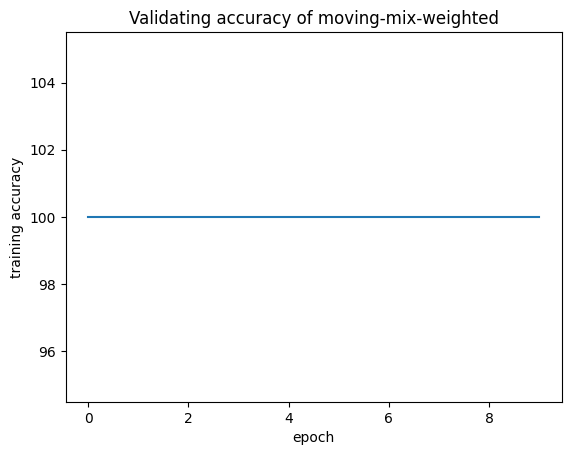

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

acc_val=[]

device = torch.device("cuda")
sensor_model = torch.load("moving_sensor.pth")
visual_model = torch.load("moving_visual.pth")
sensor_model.to(device);visual_model.to(device)
weight1=0.2
weight2=0.8
epoch=10

iterr=[]
for i in range(epoch):
    iterr.append(i)
    
total = 0
correct = 0
    
for epoch in range(epoch):
    with torch.no_grad():
        for i,(features,labels) in enumerate(val_dataloader):
            features1=features[:,0:11].to(device)
            features2=features[:,11:].to(device)
            
            outputs1 = F.softmax(sensor_model(features1))
            outputs2 = F.softmax(visual_model(features2))
            outputs = outputs1*weight1+outputs2*weight2
            _, predicted = torch.max(outputs.data, 1)
            
            predicted=predicted.to(torch.device("cpu"))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    validatingAcc = 100 * correct / total
    acc_val.append(validatingAcc)
            
    print("Epoch %d, Validating Accuracy: %.4lf%%" %(epoch+1, validatingAcc))
    
plt.figure()
plt.plot(iterr,acc_val)
plt.title('Validating accuracy of moving-mix-weighted')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.savefig('moving-mix-weighted.png')
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

acc_val=[]

device = torch.device("cuda")
sensor_model = torch.load("moving_sensor_new.pth")
visual_model = torch.load("moving_visual_new.pth")
sensor_model.to(device);visual_model.to(device)
weight1=0.2
weight2=0.8
epoch=20

iterr=[]
for i in range(epoch):
    iterr.append(i)
    
total = 0
correct = 0
    
for epoch in range(epoch):
    with torch.no_grad():
        for i,(features,labels) in enumerate(val_dataloader):
            features1=features[:,0:11].to(device)
            features2=features[:,11:].to(device)
            
            outputs1 = F.softmax(sensor_model(features1))
            outputs2 = F.softmax(visual_model(features2))
            outputs = outputs1*weight1+outputs2*weight2
            _, predicted = torch.max(outputs.data, 1)
            
            predicted=predicted.to(torch.device("cpu"))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    validatingAcc = 100 * correct / total
    acc_val.append(validatingAcc)
            
    print("Epoch %d, Validating Accuracy: %.4lf%%" %(epoch+1, validatingAcc))

'''
plt.figure()
plt.plot(iterr,acc_val)
plt.title('Validating accuracy of moving-mix-weighted')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.savefig('moving-mix-weighted.png')
plt.show()
'''

/tmp/ipykernel_552/2230375050.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs1 = F.softmax(sensor_model(features1))
/tmp/ipykernel_552/2230375050.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs2 = F.softmax(visual_model(features2))


Epoch 1, Validating Accuracy: 100.0000%
Epoch 2, Validating Accuracy: 100.0000%
Epoch 3, Validating Accuracy: 100.0000%
Epoch 4, Validating Accuracy: 100.0000%
Epoch 5, Validating Accuracy: 100.0000%
Epoch 6, Validating Accuracy: 100.0000%
Epoch 7, Validating Accuracy: 100.0000%


KeyboardInterrupt: 

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda")
sensor_model = torch.load("moving_sensor_new.pth")
visual_model = torch.load("moving_visual_new.pth")
sensor_model.to(device)
visual_model.to(device)


with torch.no_grad():
    feature=mixDataSets[26000][:-1].to(dtype=torch.float32).to(device)
    label=mixDataSets[2701][-1].to(dtype=torch.long).to(device)
    output1 = sensor_model(feature[0:11])
    output2 = visual_model(feature[11:])
    print(output1);print(output2)
 

tensor([-29.7466, -27.9178,   1.7009,   4.3177,  -4.3528,  -2.9691,  -9.2198,
        -17.2982, -13.7748,  19.9190], device='cuda:0')
tensor([[-0.1044,  0.1290, -0.0531,  0.3727, -0.0299,  0.2971, -0.4567,  0.2460,
         -0.7617, -0.1386]], device='cuda:0')


In [53]:
print(mixDataSets[0][0:11])

tensor([-2.3010, -1.0485, -1.1663, -0.8899,  0.8169,  2.9259, -0.0405, -2.2350,
         2.0172, -2.6765,  1.9647])


In [ ]:
0.2648,  0.2256,  0.0425,  0.4696, -0.0106,  0.2231, -0.3666,  0.1295,
         -0.8173, -0.3379